<a href="https://colab.research.google.com/github/Karthikeyan-ganesan86/Mscproj/blob/main/07b_DISSERT_Pairs_Trading_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAIRS TRADING WITH MACHINE LEARNING MODEL

In [ ]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
# download data from yfinance
stocks = ['GOOG','MSFT']
start_date  = "2022-01-01"
end_date  = "2022-12-31"
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
df.head()

[*********************100%%**********************]  2 of 2 completed


,GOOG,MSFT
Date,,
2022-01-03,145.074493,328.727661
2022-01-04,144.416504,323.090942
2022-01-05,137.653503,310.688171
2022-01-06,137.550995,308.233154
2022-01-07,137.004501,308.390259


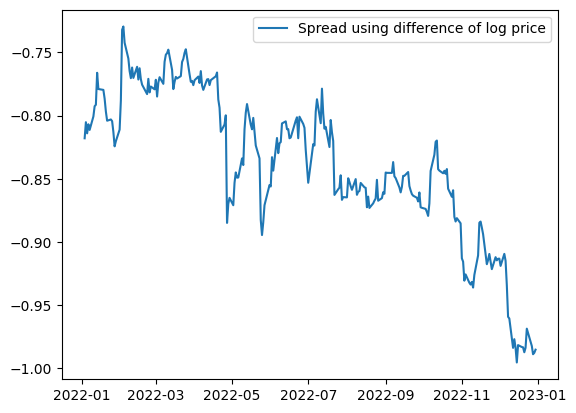

In [ ]:
spread = np.log(df[stocks[0]]) - np.log(df[stocks[1]])
plt.plot(spread, label='Spread using difference of log price')
plt.legend()
plt.show()

In [ ]:
# Define additional features
asset1_returns = np.log(df[stocks[0]]).diff()
asset2_returns = np.log(df[stocks[1]]).diff()
spread_ma5 = spread.rolling(5).mean()
asset1_volatility = asset1_returns.rolling(20).std()
asset2_volatility = asset2_returns.rolling(20).std()

In [ ]:
# Combine the features into a single DataFrame
X = pd.DataFrame({'Asset1Returns': asset1_returns,
                  'Asset2Returns': asset2_returns,
                  'SpreadMA5': spread_ma5,
                  'Asset1Volatility': asset1_volatility,
                  'Asset2Volatility': asset2_volatility})
X = X.fillna(0)
y = spread

In [ ]:
# Split the data into training and test sets
train_size = int(len(spread) * 0.8)
train_X = X[:train_size]
test_X = X[train_size:]
train_y = y[:train_size]
test_y = y[train_size:]

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
svm_model = SVR(kernel='linear')
svm_model.fit(train_X, train_y)
train_pred = svm_model.predict(train_X)
print("training rmse: ", np.sqrt(mean_squared_error(train_y, train_pred)))
test_pred = svm_model.predict(test_X)

training rmse:  0.03961603291427798


In [ ]:
import torch
def score_fn(model, type="non_neural_net"):
    # Generate predicted spread using the SVM model
    if type == "non_neural_net":
        test_pred = model.predict(test_X)
    else:
        test_pred = model(torch.Tensor(test_X.values)).detach().numpy()
    # Calculate z-score of the actual and predicted spread
    zscore = (spread - test_pred.mean()) / test_pred.std()
    # set the threshold values for entry and exit signals
    entry_threshold = 2.0
    exit_threshold = 1.0
    # initialize the daily positions to be zeros
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    # generate daily entry and exit signals for each stock

    for i in range(1, len(zscore)):
        # zscore<-2 and no existing long position for stock 1
        if zscore[i] < -entry_threshold and stock1_position[i-1] == 0:
            stock1_position[i] = 1 # long stock 1
            stock2_position[i] = -1 # short stock 2
        # zscore>2 and no existing short position for stock 2
        elif zscore[i] > entry_threshold and stock2_position[i-1] == 0:
            stock1_position[i] = -1 # short stock 1
            stock2_position[i] = 1 # long stock 2
        # -1<zscore<1
        elif abs(zscore[i]) < exit_threshold:
            stock1_position[i] = 0 # exit existing position
            stock2_position[i] = 0
        # -2<zscore<-1 or 1<zscore<2
        else:
            stock1_position[i] = stock1_position[i-1] # maintain existing position
            stock2_position[i] = stock2_position[i-1]
    # Calculate the returns of each stock
    stock1_returns = (np.exp(test_X['Asset1Returns']) * stock1_position.shift(1)).fillna(0)
    stock2_returns = (np.exp(test_X['Asset2Returns']) * stock2_position.shift(1)).fillna(0)
    # calculate the total returns of the strategy
    total_returns = stock1_returns + stock2_returns
    cumulative_returns = (1 + total_returns).cumprod()
    return cumulative_returns[-1]

In [ ]:
score_fn(svm_model)

1.1437468701707865

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
# Create random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model on the training and test set
rf_model.fit(train_X, train_y)
train_pred = rf_model.predict(train_X)

In [ ]:
print("training rmse: ", np.sqrt(mean_squared_error(train_y, train_pred)))

training rmse:  0.00562669508299927


In [ ]:
test_pred = rf_model.predict(test_X)

In [ ]:
print("test rmse: ", np.sqrt(mean_squared_error(test_y, test_pred)))

test rmse:  0.07339128155386529


In [ ]:
score_fn(rf_model)

0.9129383490959507